# Simultaneous Regression Run

Imports

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt
from sklearn import neighbors
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor

Load and Describe Data

In [2]:
def load_pp_data():
    csv_path = r"C:\Users\18123\OneDrive\Documents\IU Bloomington\Machine-Learning-Project\PowerPlantData\CCPP\Folds5x2_pp.csv"
    return pd.read_csv(csv_path)

pp = load_pp_data()
print(pp.describe())

                AT            V           AP           RH           PE
count  9568.000000  9568.000000  9568.000000  9568.000000  9568.000000
mean     19.651231    54.305804  1013.259078    73.308978   454.365009
std       7.452473    12.707893     5.938784    14.600269    17.066995
min       1.810000    25.360000   992.890000    25.560000   420.260000
25%      13.510000    41.740000  1009.100000    63.327500   439.750000
50%      20.345000    52.080000  1012.940000    74.975000   451.550000
75%      25.720000    66.540000  1017.260000    84.830000   468.430000
max      37.110000    81.560000  1033.300000   100.160000   495.760000


Split Train/Test Data

In [3]:
pp["AT_cat"] = pd.cut(pp["AT"],bins=[0.,10.,20.,30.,np.inf],labels=[1,2,3,4])

split = StratifiedShuffleSplit(n_splits=1,test_size=0.2,random_state=42)
for train_index, test_index in split.split(pp,pp["AT_cat"]):
    train_set = pp.loc[train_index]
    test_set = pp.loc[test_index]

for set_ in(train_set,test_set):
    set_.drop("AT_cat",axis=1,inplace=True)

pptrain = train_set.copy()
pptest = test_set.copy()

pptrain_attrib = pptrain.drop("PE",axis=1)
pptrain_labels = pptrain["PE"].copy()
pptest_attrib = pptest.drop("PE",axis=1)
pptest_labels = pptest["PE"].copy()

scaler = StandardScaler()
scaler.fit_transform(pptrain_attrib)

array([[ 1.1978498 ,  0.96554795,  0.37377565, -2.67409022],
       [ 0.64009018, -1.03750958, -1.88469509, -2.35340963],
       [-1.82211612, -1.45609422, -0.36887464,  1.17611946],
       ...,
       [-1.07754063, -0.84989538,  0.57724148,  0.20454577],
       [-0.67971691, -0.96104497,  0.78748951,  0.87314098],
       [ 0.89545   ,  0.56351752, -0.13658448, -1.12107019]])

Dictionary of Regression Hyperparamter Ranges

In [4]:
regression_param_dict = {
DecisionTreeRegressor: [{'ccp_alpha': sp_randFloat(0,1), 'criterion': ['squared_error','friedman_mse','absolute_error','poisson'], 'max_depth': sp_randInt(1,100), 'max_features': [None,'sqrt','log2'], 'max_leaf_nodes': sp_randInt(2,100), 'min_impurity_decrease': sp_randFloat(0,1), 'min_samples_leaf': sp_randInt(1,100), 'min_samples_split': sp_randInt(2,100), 'min_weight_fraction_leaf': sp_randFloat(0,0.5), 'random_state': [10], 'splitter': ['best','random']}],
LinearRegression: [{'copy_X': [True], 'fit_intercept': [True, False], 'n_jobs': [None], 'normalize': ['deprecated'], 'positive': [True,False]}],
GaussianProcessRegressor: [{'alpha': sp_randFloat(1e-11,1e-9), 'copy_X_train': [True], 'kernel': [None], 'n_restarts_optimizer': sp_randInt(0,10), 'normalize_y': [True,False], 'optimizer': ['fmin_l_bfgs_b'], 'random_state': [10]}],
neighbors.KNeighborsRegressor: [{'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'], 'leaf_size': sp_randInt(1,100), 'metric': ['minkowski'], 'metric_params': [None], 'n_jobs': [None], 'n_neighbors': sp_randInt(1,50), 'p': sp_randInt(1,2), 'weights': ['uniform','distance']}],
RandomForestRegressor: [{'bootstrap': [True,False], 'ccp_alpha': sp_randFloat(0,1), 'criterion': ['squared_error', 'absolute_error', 'poisson'], 'max_depth': sp_randInt(1,100), 'max_features': [None,'sqrt','log2'], 'max_leaf_nodes': sp_randInt(2,100), 'max_samples': [None], 'min_impurity_decrease': sp_randFloat(0,1), 'min_samples_leaf': sp_randInt(1,100), 'min_samples_split': sp_randInt(2,100), 'min_weight_fraction_leaf': sp_randFloat(0,0.5), 'n_estimators': sp_randInt(1,50), 'n_jobs': [None], 'oob_score': [False], 'random_state': [10], 'verbose': [0], 'warm_start': [False]}]
}

Function that Runs Regressions Simultaneously

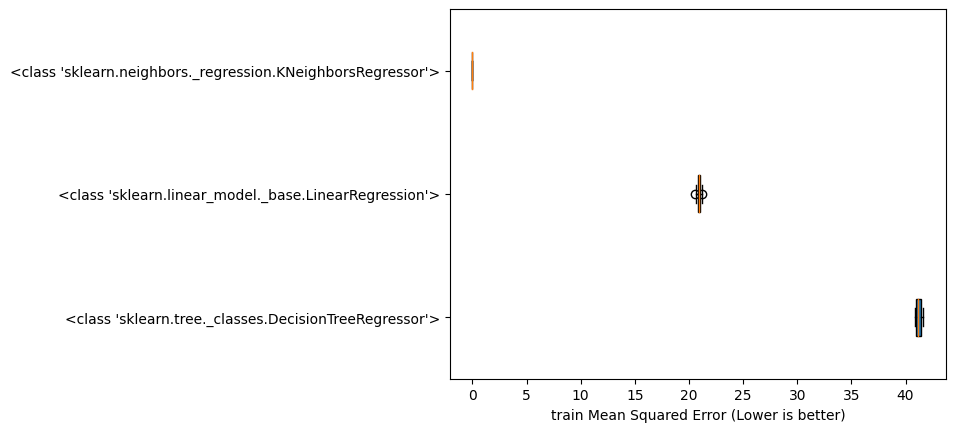

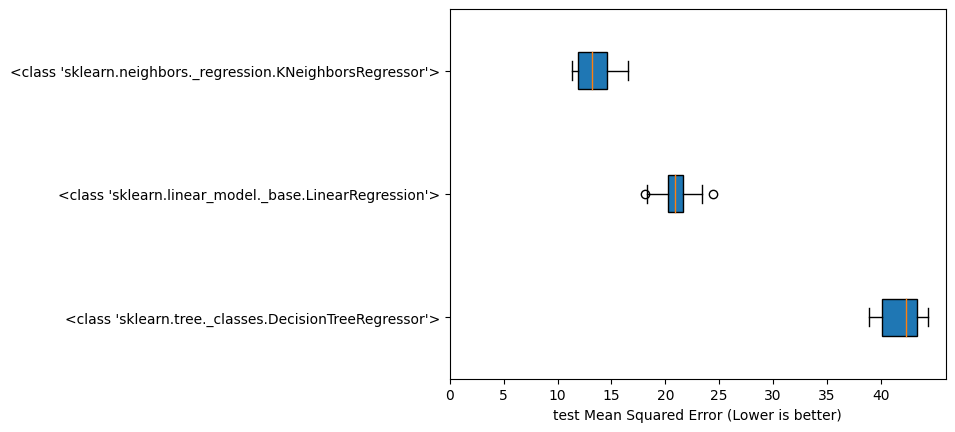

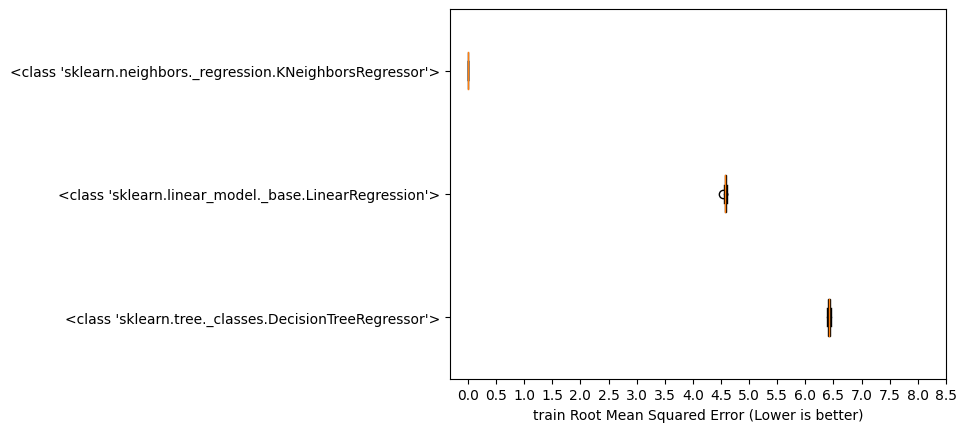

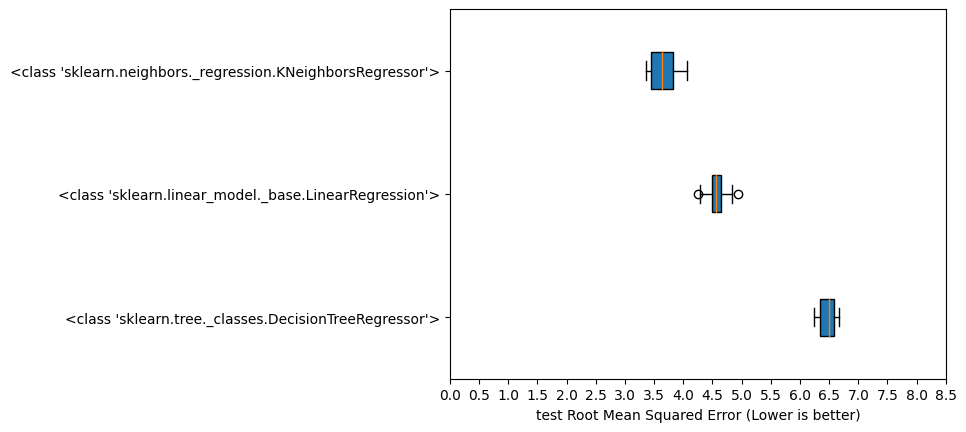

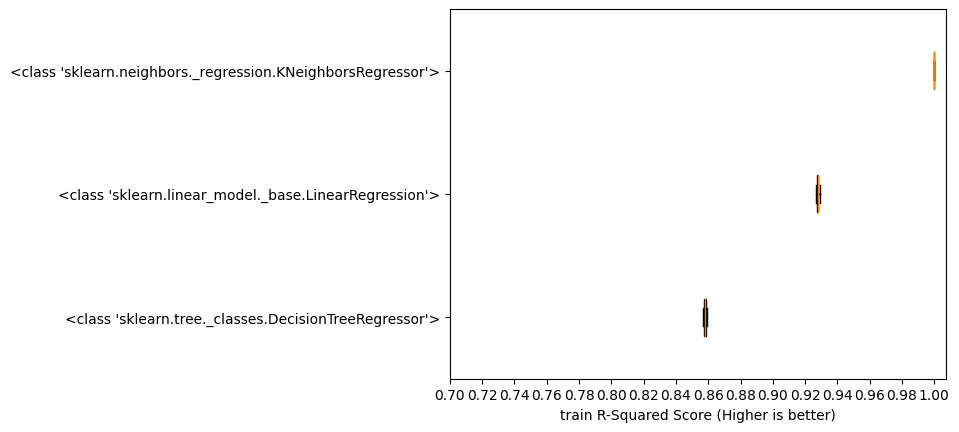

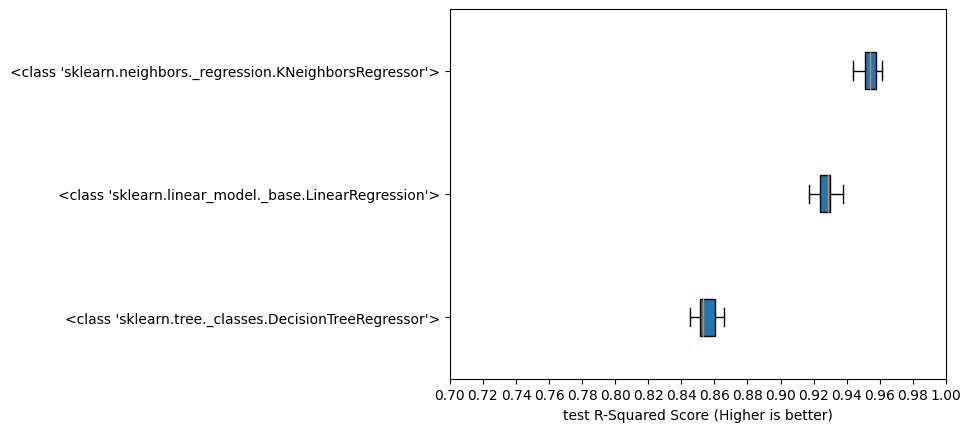

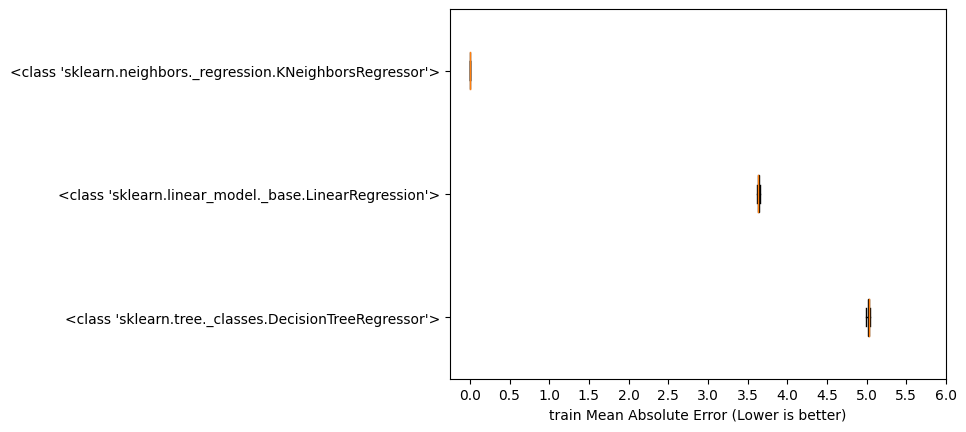

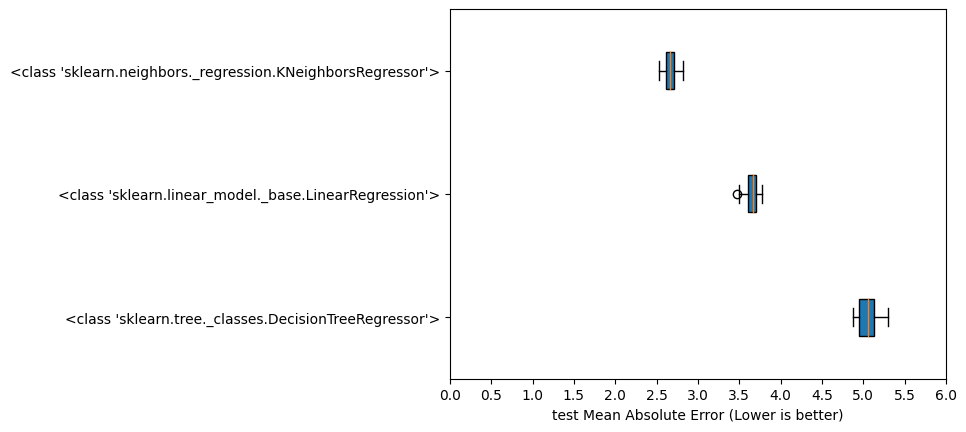

In [5]:
def run(model):
    reg = model()
    param_grid = regression_param_dict[model]

    if model == LinearRegression:
        xiter = 4
    else:
        xiter = 10 

    cv_inner = KFold(n_splits=5, shuffle= True, random_state=1)
    reg_hyper_search = RandomizedSearchCV(reg,param_grid,scoring="neg_mean_squared_error",cv=cv_inner,n_iter=xiter,refit=True,random_state=12)
    
    cv_outer = KFold(n_splits=10, shuffle=True, random_state=2)
    cv_output_dict = cross_validate(reg_hyper_search, pptrain_attrib, pptrain_labels, scoring=["neg_mean_squared_error","neg_mean_absolute_error","r2"], cv=cv_outer, return_train_score=True, return_estimator=True)
    
    return cv_output_dict


def comparison(modellst):
    cv_data = []
    for i in modellst:
        cv_data += [run(i)]
    return box_plots(cv_data, modellst)

def box_plots(cv_data, modellst):
    return box_mse(cv_data, modellst,'train'), box_mse(cv_data, modellst, 'test'), box_rmse(cv_data, modellst, 'train'), box_rmse(cv_data, modellst, 'test'), box_r2(cv_data, modellst, 'train'), box_r2(cv_data, modellst, 'test'), box_mae(cv_data, modellst, 'train'), box_mae(cv_data, modellst, 'test'),

def box_mse(cv_data, modellst, data_split):
    MSEfig = plt.figure()
    x = []
    for i in cv_data:
        x += [i[data_split+'_neg_mean_squared_error']*-1]
    plt.boxplot(x,vert=False,patch_artist=True,labels=[*modellst])
    plt.xticks([*range(0,45,5)])
    plt.xlabel(f'{data_split} Mean Squared Error (Lower is better)')
    return MSEfig

def box_rmse(cv_data, modellst, data_split):
    RMSEfig = plt.figure()
    x = []
    for i in cv_data:
        x += [np.sqrt(i[data_split+'_neg_mean_squared_error']*-1)]
    plt.boxplot(x,vert=False,patch_artist=True,labels=[*modellst])
    xticklst = []
    for j in range(0,90,5):
        xticklst += [j/10]
    plt.xticks(xticklst)
    plt.xlabel(f'{data_split} Root Mean Squared Error (Lower is better)')
    return RMSEfig

def box_r2(cv_data, modellst, data_split):
    R2fig = plt.figure()
    x = []
    for i in cv_data:
        x += [i[data_split+'_r2']]
    plt.boxplot(x,vert=False,patch_artist=True,labels=[*modellst])
    xticklst = []
    for j in range(70,102,2):
        xticklst += [j/100]
    plt.xticks(xticklst)
    plt.xlabel(f'{data_split} R-Squared Score (Higher is better)')
    return R2fig

def box_mae(cv_data, modellst, data_split):
    MAEfig = plt.figure()
    x = []
    for i in cv_data:
        x += [i[data_split+'_neg_mean_absolute_error']*-1]
    plt.boxplot(x,vert=False,patch_artist=True,labels=[*modellst])
    xticklst = []
    for j in range(0,650,50):
        xticklst += [j/100]
    plt.xticks(xticklst)
    plt.xlabel(f'{data_split} Mean Absolute Error (Lower is better)')
    return MAEfig

x = [DecisionTreeRegressor,LinearRegression,GaussianProcessRegressor,RandomForestRegressor,neighbors.KNeighborsRegressor]
y = [DecisionTreeRegressor,LinearRegression,neighbors.KNeighborsRegressor]
comparison(y)
plt.show()